## *Import Libraries*

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Craiglist/criaglist_clearv3.parquet')

## *Split Data*

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop(columns=['price'])
y = df[['price']]

In [ ]:
X.columns

Index(['year', 'cylinders', 'odometer', 'title_status', 'transmission',
       'engine_size', 'hp', 'premium', 'acura', 'audi',
       ...
       'minivan', 'pickup', 'sedan', 'truck', 'van', 'wagon', 'germany',
       'japan', 'south korea', 'usa'],
      dtype='object', length=425)

In [ ]:
len(X.columns)

425

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [ ]:
X_train.shape[0],X_val.shape[0],X_test.shape[0]

(92404, 23101, 28877)

### *Scaler Data*

In [ ]:
from sklearn.preprocessing import StandardScaler,RobustScaler

In [ ]:
scaler = StandardScaler().fit(X_train)

In [ ]:
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
robust = RobustScaler().fit(y_train)

In [ ]:
y_train = robust.transform(y_train)
y_val = robust.transform(y_val)
y_test = robust.transform(y_test)

In [ ]:
def array(x):
    return np.asarray(x)

In [ ]:
X_train,y_train = array(X_train),array(y_train)
X_test,y_test = array(X_test),array(y_test)
X_val,y_val = array(X_val),array(y_val)

## *Model*

In [ ]:
import torch

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x = torch.from_numpy(x).float().to('cuda')
        self.y = torch.from_numpy(y).float().to('cuda')

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self,index):
        return self.x[index],self.y[index]

In [ ]:
trainDataset = Dataset(X_train,y_train)
valDataset = Dataset(X_val,y_val)

In [ ]:
trainDataloader = torch.utils.data.DataLoader(trainDataset,
                                              batch_size = 32,
                                              shuffle = True)

valDataloader = torch.utils.data.DataLoader(valDataset,
                                              batch_size = 16,
                                              shuffle = True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
X_train.shape[1]

425

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()

        self.fc1 = nn.Linear(in_features = 425,out_features = 64)
        self.fc2 = nn.Linear(in_features = 64,out_features = 32)
        self.fc3 = nn.Linear(in_features= 32,out_features=16)
        self.output = nn.Linear(in_features = 16,out_features = 1)

    def forward(self,x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return self.output(x)

In [ ]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(),lr =  0.0005)
loss = nn.MSELoss()

In [ ]:
model.to('cuda')

Model(
  (fc1): Linear(in_features=425, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
def train(dataloader):

    model.train()
    for xi,yi in dataloader:
        xi = xi.to('cuda')
        yi = yi.to('cuda')
        pred = model(xi)
        loss_fc = loss(pred,yi)

        optimizer.zero_grad()
        loss_fc.backward()
        optimizer.step()

    return loss_fc.item()


@torch.no_grad()
def val(dataloader):

    model.eval()

    for xi,yi in dataloader:
        xi = xi.to('cuda')
        yi = yi.to('cuda')
        pred = model(xi)
        loss_fc = loss(pred,yi)


    return loss_fc.item()

In [ ]:
epochs = np.arange(1,35,1)
loss_train_list = []
loss_val_list = []
epoch_list = []

In [ ]:

for epoch in epochs:

  loss_train,loss_val = train(trainDataloader),val(valDataloader)

  loss_train_list.append(loss_train)
  loss_val_list.append(loss_val)
  epoch_list.append(epoch)

  print(f'Epoch:  {epoch} loss train: {loss_train} loss test: {loss_val} ')

Epoch:  1 loss train: 0.03603559732437134 loss test: 0.12502844631671906 
Epoch:  2 loss train: 0.05934036895632744 loss test: 0.07340963929891586 
Epoch:  3 loss train: 0.027311641722917557 loss test: 0.03856561705470085 
Epoch:  4 loss train: 0.04325094446539879 loss test: 0.07591462135314941 
Epoch:  5 loss train: 0.05079204961657524 loss test: 0.1340082436800003 
Epoch:  6 loss train: 0.029628753662109375 loss test: 0.07619889825582504 
Epoch:  7 loss train: 0.5072054266929626 loss test: 0.05526353791356087 
Epoch:  8 loss train: 0.051646213978528976 loss test: 0.10959623008966446 
Epoch:  9 loss train: 0.14029419422149658 loss test: 0.04595876485109329 
Epoch:  10 loss train: 0.15720751881599426 loss test: 0.040663812309503555 
Epoch:  11 loss train: 0.019404053688049316 loss test: 0.009974675253033638 
Epoch:  12 loss train: 0.09664316475391388 loss test: 0.1423385739326477 
Epoch:  13 loss train: 0.05979309603571892 loss test: 0.03183542564511299 
Epoch:  14 loss train: 0.035015

## *History*

In [ ]:

plt.style.use('ggplot')

In [ ]:

history = pd.DataFrame()
history['epoch'] = epoch_list
history['loss_train'] = loss_train_list
history['loss_val'] = loss_val_list

In [ ]:

plt.style.use('ggplot')

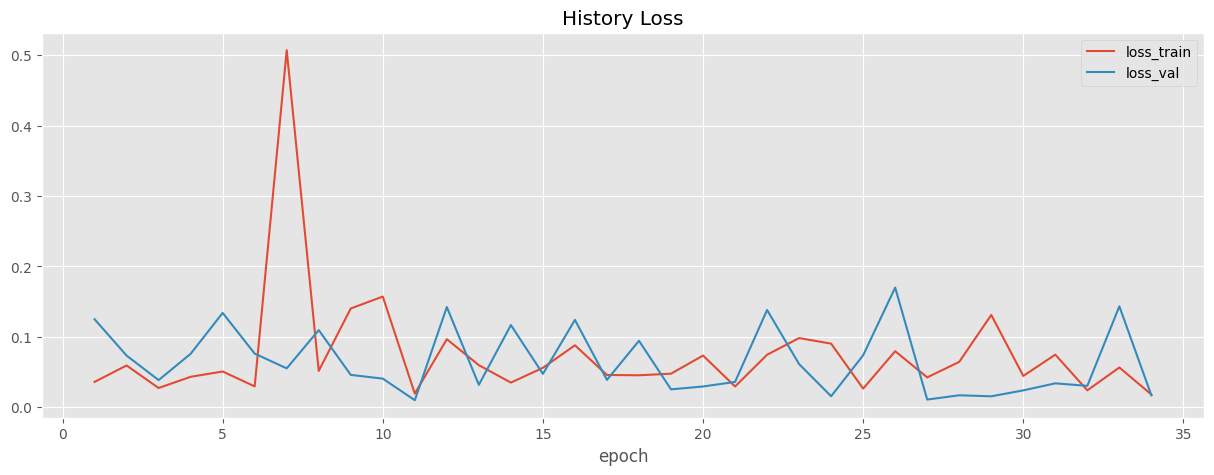

In [ ]:
fig,ax = plt.subplots(1,1,figsize = (15,5))
ax.set_title('History Loss')
history.plot(x = "epoch",y = "loss_train",ax = ax)
history.plot(x = "epoch",y = "loss_val",ax = ax)
plt.show()

In [ ]:
X_test = torch.from_numpy(X_test).to('cuda').float()

In [ ]:
pred_train = model(trainDataset.x).detach().to('cpu')
pred_val = model(valDataset.x).detach().to('cpu')
pred_test = model(X_test).detach().to('cpu')

In [ ]:
y_test_robust = robust.inverse_transform(y_test)
pred = model(X_test).detach().to('cpu')
pred_robust = robust.inverse_transform(pred)

## *Metrics*

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score

### *RMSE*

In [ ]:
def RMSE(y_true,y_pred):

    y_true = robust.inverse_transform(y_true)
    y_pred = robust.inverse_transform(y_pred)

    return np.sqrt(mean_squared_error(y_true,y_pred))

In [ ]:
rmse_train = RMSE(y_train,pred_train)
rmse_val = RMSE(y_val,pred_val)
rmse_test = RMSE(y_test,pred_test)

In [ ]:
print(f'RMSE Train: {rmse_train}')
print(f'RMSE Test:  {rmse_test}')
print(f'RMSE Val:   {rmse_val}')

RMSE Train: 3505.0046974251713
RMSE Test:  3690.414729723677
RMSE Val:   3690.170814505493


In [ ]:
def R2(y_true,y_pred):

    y_true = robust.inverse_transform(y_true)
    y_pred = robust.inverse_transform(y_pred)


    return r2_score(y_true,y_pred)

In [ ]:
r2_train = R2(y_train,pred_train)
r2_val = R2(y_val,pred_val)
r2_test = R2(y_test,pred_test)

In [ ]:
print(f'R2 Train: {r2_train}')
print(f'R2 Test:  {r2_test}')
print(f'R2 Val:   {r2_val}')

R2 Train: 0.9144304470473031
R2 Test:  0.9040815897305579
R2 Val:   0.9048984660944253


### *Predict New Data*

In [ ]:
columns =  X.columns

In [ ]:
np.where('germany'==columns)

(array([421]),)

In [ ]:
def predict(country,manufacturer,model_car,body,year,odometer,cyl,engine,fuel,transmission,hp,title_status):
    zeros = np.zeros(len(columns))
    title_status_dict = {'missing':0,'lien':1,'salvage':2,'rebuilt':3,'clean':4}
    zeros[0] = year
    zeros[1] = cyl
    zeros[2] = np.sqrt(odometer)
    zeros[3] = title_status_dict[title_status]
    zeros[4] = np.where(transmission=="automatic",1,0)
    zeros[5] = engine
    zeros[6] = hp
    premium_list =  ['gmc','cadillac','audi','bmw','mercedes-benz','infiniti','acura','lexus']
    if manufacturer in premium_list:
        zeros[7] = 1
    else:
        zeros[7] = 0


    manufacturer_idx = np.where(manufacturer == columns)[0][0]
    fuel_idx = np.where(fuel == columns)[0][0]
    type_body_idx = np.where(body == columns)[0][0]
    country_idx = np.where(country == columns)[0][0]
    model_idx = np.where(model_car == columns)[0][0]

    if manufacturer_idx >= 0:
        zeros[manufacturer_idx] = 1


    if fuel_idx >=0:
        zeros[fuel_idx] = 1


    if type_body_idx>=0:
        zeros[type_body_idx] = 1

    if country_idx>=0:
        zeros[country_idx] = 1


    if model_idx>=0:
        zeros[model_idx] = 1

    zeros = np.asarray([zeros])

    zeros = scaler.transform(zeros)
    zeros = torch.from_numpy(zeros).float().to('cuda')
    pred = model(zeros).detach().to('cpu').float()




    return robust.inverse_transform(pred)

In [ ]:
predict('germany','mercedes-benz','c-class','sedan',2021,12456,4,2.0,'gas','automatic',255,'clean')

array([[34659.31500518]])

In [ ]:
predict('usa','jeep','wrangler','SUV',2020,35364,6,3.6,'gas','manual',285,'clean')

array([[46326.88081646]])

In [ ]:
predict('japan','toyota','tacoma','pickup',2015,105281,6,4.0,'gas','automatic',236,'clean')

array([[26300.60242736]])

In [ ]:
predict('germany','bmw','5 series','sedan',2023,5741,6,3.0,'gas','automatic',332,'clean')

array([[66179.104177]])

### *Save scaler objects*

In [ ]:
import joblib

In [ ]:
joblib.dump(scaler,'scaler.pkl')

['scaler.pkl']

In [ ]:
joblib.dump(robust,'robust.pkl')

['robust.pkl']

### *JSON File*

In [ ]:
import json

In [ ]:
columns = X.columns
columns = {"columns":[col for col in columns]}

with open("columns.json","w") as F:

    F.write(json.dumps(columns))

We save the name of the columns in JSON format to help capture the new data.

### *Save Model*

In [ ]:
torch.save(model.state_dict(),'model.pth')

We save the previously trained model to use it to predict new data.